# Prelude

We first import the usual suspects, then take a quick peek at the data.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
from sklearn.model_selection import learning_curve

In [2]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


Let's now take a look at the skin color ratings.

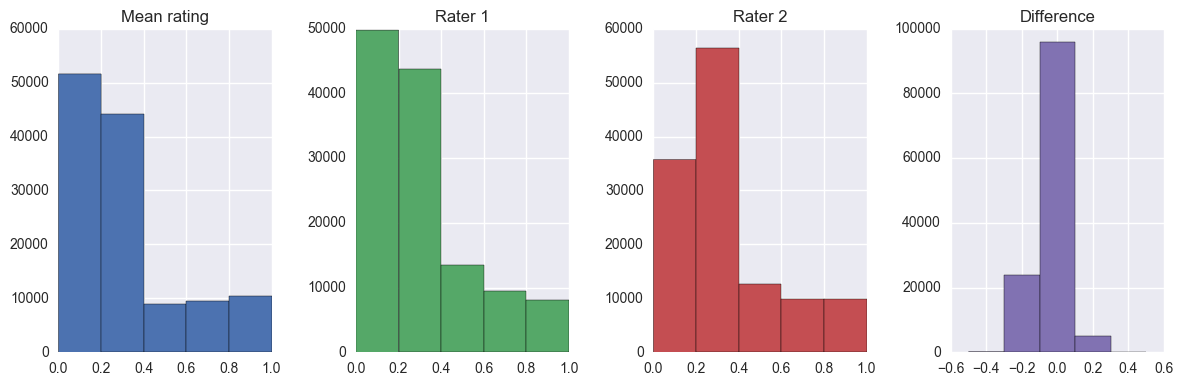

In [3]:
f, axe = plt.subplots(1, 4, figsize=(12, 4))

mean_skin = ((data['rater1'] + data['rater2']) /2).dropna()

axe[0].hist(mean_skin, bins=5, range= (0, 1), color = sns.color_palette()[0])
axe[0].set_title("Mean rating")

axe[1].hist(data['rater1'].dropna(), bins=5, range= (0,1), color=sns.color_palette()[1])
axe[1].set_title("Rater 1")

axe[2].hist(data['rater2'].dropna(), bins=5, range =(0, 1), color = sns.color_palette()[2])
axe[2].set_title('Rater 2')

axe[3].hist((data['rater1'] - data['rater2']).dropna(), bins=5, range = (-0.5, 0.5), color = sns.color_palette()[3])
axe[3].set_title("Difference")
f.tight_layout()

There seems to be some disagreement between the two rater for the lower end of the skin color spectrum.   
This difference of rating could probably be reduced by having more raters for each player. 

This brings up an interesting issue: how are we supposed to classify players by skin color correctly if even two humans disagree around 20% of the time?  
The most obvious way to counteract this is to discretize the skin color rating in black/white instead of having a continuous scale from 0 to 1.

Cleaning up
===========
We will now proceed to clean up missing data and irrelevant values inside the dataset.

In [4]:
# We now have to combine both ratings of skin color into to have only one response variable and simplify the process
# Really don't know why we care about disaggregation...
df = pd.read_csv('CrowdstormingDataJuly1st.csv')

total = len(df)

print("%d players known" % total)

df['skintone'] = (df['rater1'] + df['rater2']) / 2
del df['rater1']
del df['rater2']

# We then need to remove players for which at least one the skin rating is NaN since we can't train the classifier with those
cleaned = df.dropna(axis=0, subset=['skintone'])

print("Removed %d invalid players" % (total - len(cleaned)))

146028 players known
Removed 21407 invalid players


There might be other features which are NaN left in the set let's see what they are.

In [5]:
for c in cleaned.columns:
    print(c + ": " + str(len(cleaned[cleaned[c].isnull()])))

playerShort: 0
player: 0
club: 0
leagueCountry: 0
birthday: 0
height: 46
weight: 753
position: 8461
games: 0
victories: 0
ties: 0
defeats: 0
goals: 0
yellowCards: 0
yellowReds: 0
redCards: 0
photoID: 0
refNum: 0
refCountry: 0
Alpha_3: 1
meanIAT: 153
nIAT: 153
seIAT: 153
meanExp: 153
nExp: 153
seExp: 153
skintone: 0


We notice there are a lot of players with no position but hopefully a smart coach will not put a player at a certain position based on his skin color but rather based on his skill ;)

We also notice that the same set of players don't have the \*IAT and \*Exp variables set! This makes senses since those are collected per country. However considering the size of our dataset there are very few entries with no IAT and Exp so we can drop those without much concern!

In [6]:
cleaned = cleaned.dropna(axis=0, subset=['meanIAT'])

assert cleaned[cleaned['nExp'].isnull()].empty # This confirms that the *IAT and *Exp are NaN for the same set of players

For the weight and height features it makes sense to assume that the players have a rather similar build because of playing footbal professionnaly (essentially the same diet and exercise schedule). So we can approximate the NaN values with the mean weight and mean height respectively.

In [7]:
mean_weight = cleaned['weight'].mean()
mean_height = cleaned['height'].mean()

cleaned['weight'].fillna(mean_weight, inplace=True)
cleaned['height'].fillna(mean_height, inplace=True)

In [8]:
print(str(len(cleaned)) + " players in the dataset")

assert cleaned[cleaned['height'].isnull() | cleaned['weight'].isnull()].empty

124468 players in the dataset


We are now reasonably confident that we have a cleaned dataset and we proceed to the actual classification task.

We now discretize the skintone values to include only 3 possible outcomes (white, métisse and black). This will make it simpler to obtain good classification result.

In [9]:
def map_discretize(val):
    if val < 0.5:
        return 0
    else:
        return 1

cleaned['skintone'] = cleaned['skintone'].apply(map_discretize)

Classification
============

Let's first clean up the dataset a bit.

In [10]:
r = cleaned.copy()
r = r.groupby('playerShort').agg('first') # Only keep one entry per player
r = r.dropna().drop('player', axis=1)

r.columns

Index(['club', 'leagueCountry', 'birthday', 'height', 'weight', 'position',
       'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards',
       'yellowReds', 'redCards', 'photoID', 'refNum', 'refCountry', 'Alpha_3',
       'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp', 'skintone'],
      dtype='object')

Label encoding
----------------------
Since scikit-learn only supports numerical data we need to create a mapping between our textual data and a numerical representation. We do this using the LabelEncoder from scikit-learn. See [here](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [11]:
from sklearn.preprocessing import LabelEncoder

r.dropna(inplace=True)
features = r.drop('skintone', axis=1) # The features df is the same but without the response variable

for f in features.columns:
    encoder = LabelEncoder()
    labels = encoder.fit_transform(features[f])
    features[f] = labels

print(str(len(np.unique(r['skintone']))) + " unique skintone values in the set")

2 unique skintone values in the set


Classifier parameters examination
------------------------------------------------------

1. n_estimators
---------------

We first examine the impact of the n_estimators parameter on the classifier 

In [13]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

n_estimators_range = np.linspace(1, 100)
acc = []

for i in n_estimators_range:
    forest = RandomForestClassifier(n_estimators=int(i))
    cv_score = np.mean(cross_val_score(forest, features, r['skintone'], cv=9))
    acc.append(cv_score)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


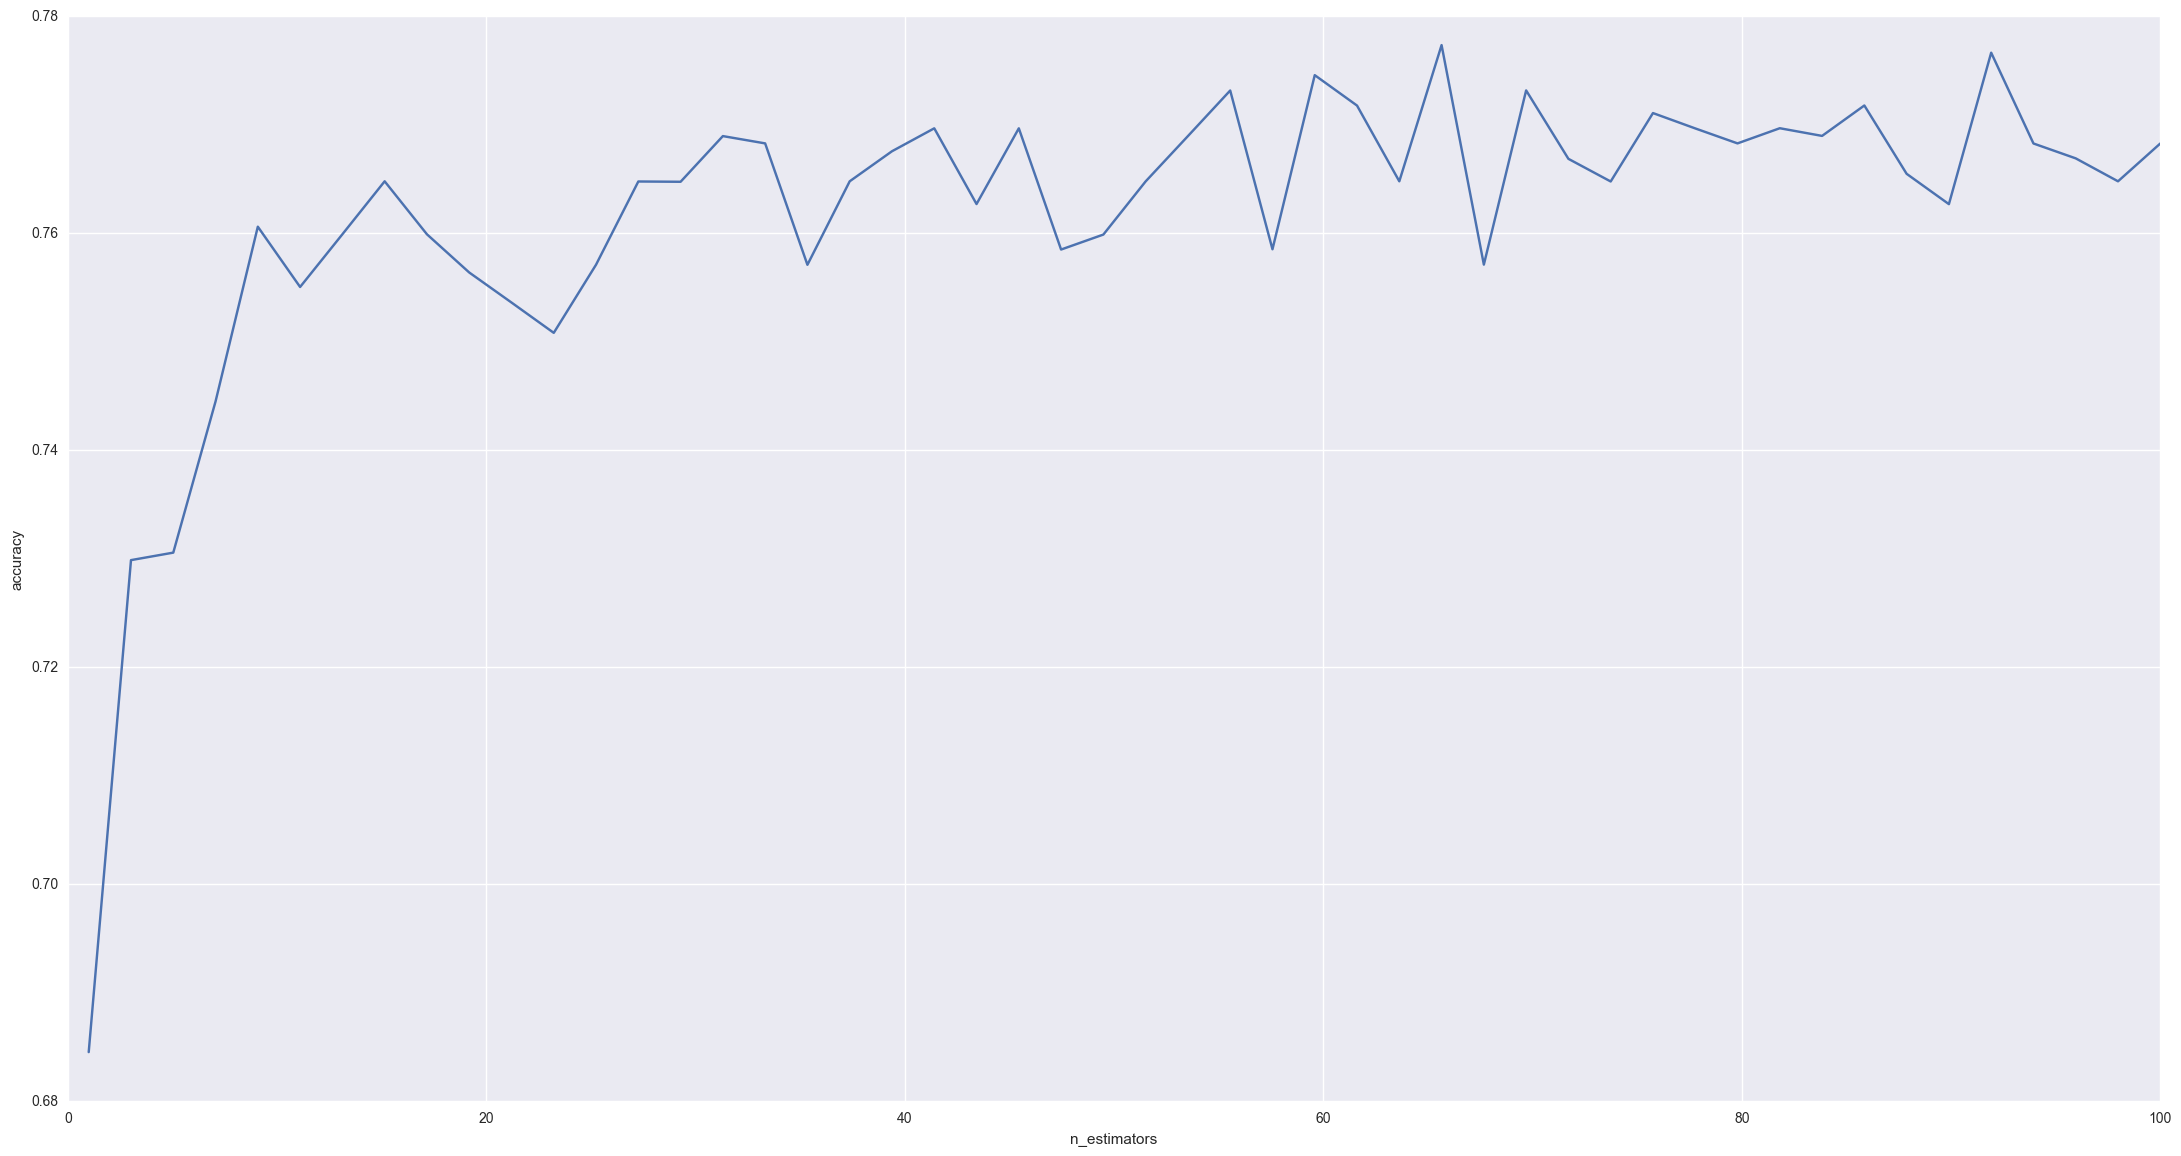

In [14]:
def plot_xy(x, y, xn, yn):
    f, axes = plt.subplots(figsize=(27, 14))
    axes.plot(x, y)
    axes.set_xlabel(xn)
    axes.set_ylabel(yn)
    f.show()

# This triggers a warning saying the figure cannot be shown. Yet the figure is shown anyway. Go figure...
plot_xy(n_estimators_range, acc, "n_estimators", "accuracy")

We conclude that the optimal `n_estimators` is 46.

2. max_features
-------------------
We now examine the max_features parameter

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


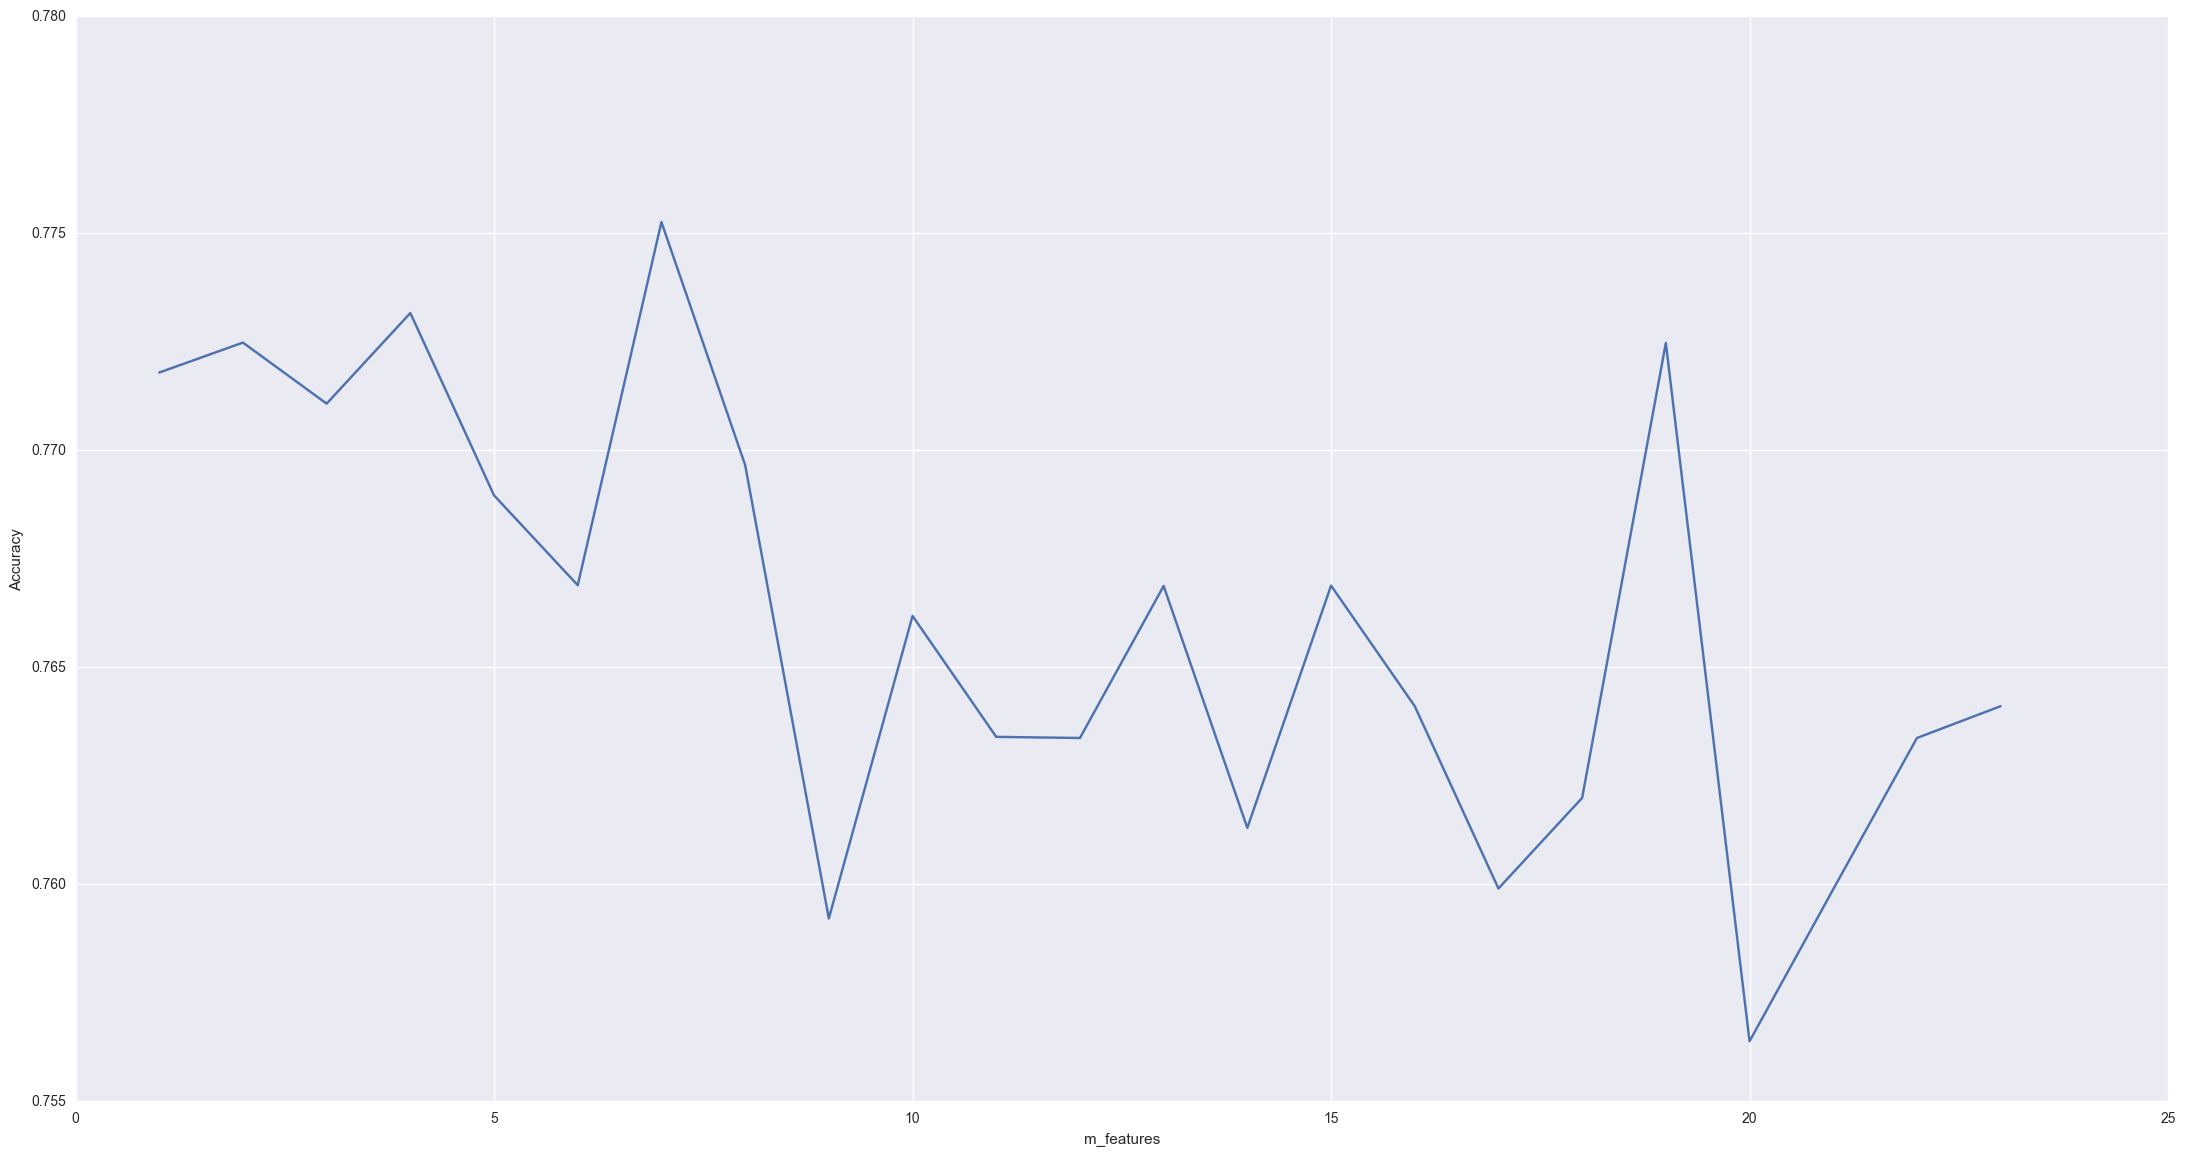

In [30]:
m_features_range = range(1, features.shape[1])

m_features_accuracies = []

for i in m_features_range:
    clf = RandomForestClassifier(max_features=i, n_estimators=46)
    score = np.mean(cross_val_score(clf, features, r['skintone'], cv=9))
    m_features_accuracies.append(score)

plot_xy(m_features_range, m_features_accuracies, "m_features", "Accuracy")

We see that the classifier seems to be the most accurate with a max_features value of 7 so we select it for our final model.

3. max_depth
-----------------------

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


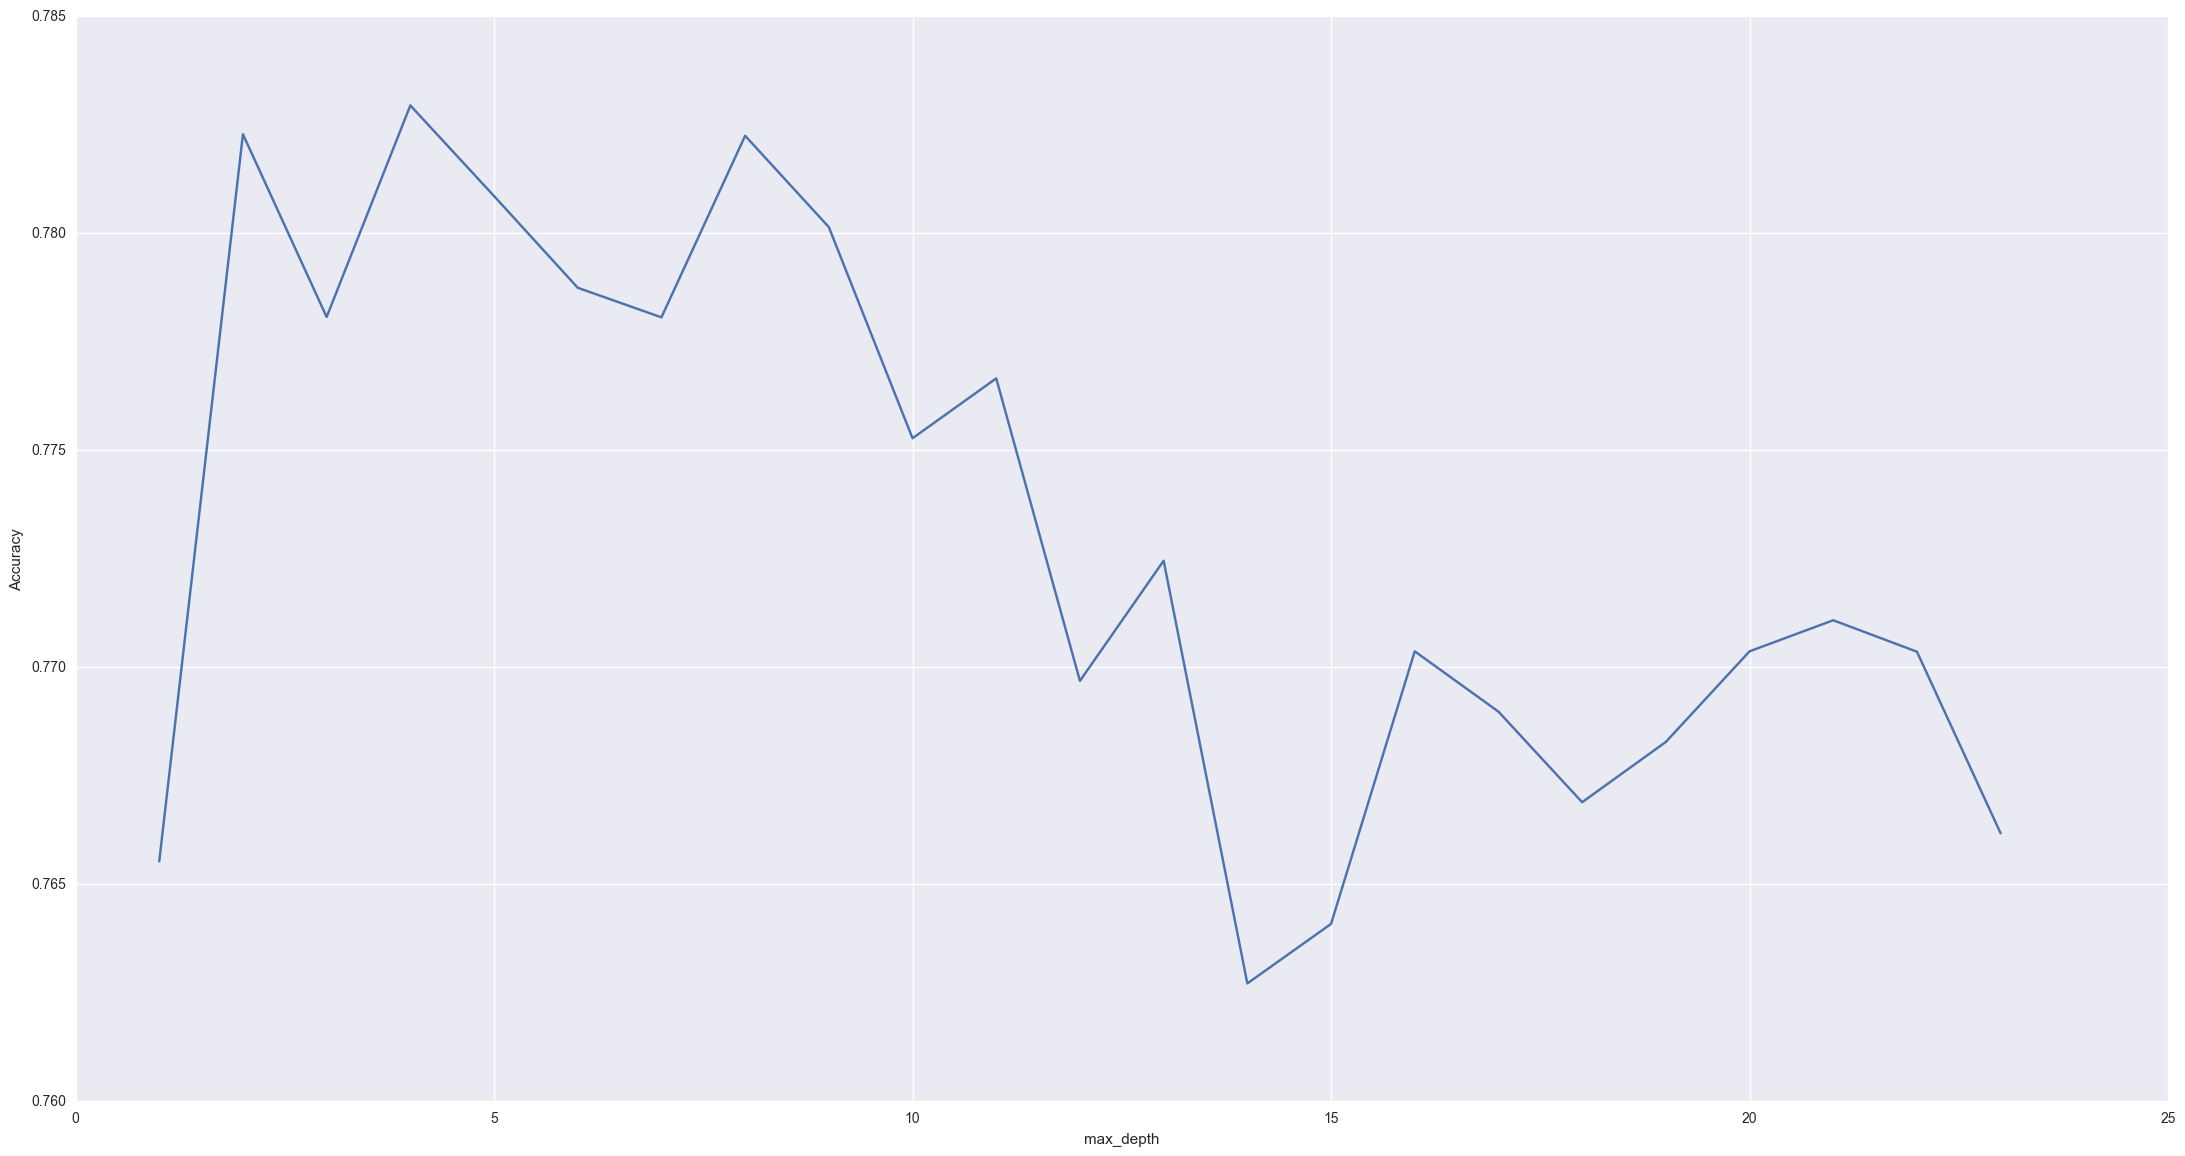

In [31]:
max_depth_range = range(1, 30)

m_features_accuracies = []

for i in m_features_range:
    clf = RandomForestClassifier(max_depth=i, n_estimators=46, max_features=7)
    score = np.mean(cross_val_score(clf, features, r['skintone'], cv=9))
    m_features_accuracies.append(score)

plot_xy(m_features_range, m_features_accuracies, "max_depth", "Accuracy")

This plot leads us to select a value of 4 for the max_depth parameter.

Random Forest Classifier training
--------------------------------------

In [32]:
from sklearn.cross_validation import train_test_split

def make_forest(n_features=7):
    return RandomForestClassifier(n_estimators=46, max_features=n_features, max_depth=4)

X_train, X_test, y_train, y_test = train_test_split(features, r['skintone'], test_size=0.3)

model = make_forest()

clf = model.fit(X_train, y_train)

In [33]:
clf.score(X_test, y_test)

0.79534883720930227

In [34]:
score = cross_val_score(clf, X_test, y_test, cv=9)

print("Accuracy: %f with std of -+ %0.5f" % (score.mean(), score.std()*2))

Accuracy: 0.795320 with std of -+ 0.02634


We have a pretty good accuracy already. Let's try to reduce the complexity of our model by selecting features in an intelligent fashion.

Feature importances
-------------------------

We will now examine the importance of each feature in our model and determine which one can be safely removed

In [35]:
indices = []

indices.clear()

for idx in range(len(features.columns)):
    indices.append((clf.feature_importances_[idx], idx))
    
indices = sorted(indices, key=lambda s : s[0], reverse=True)
indices

[(0.17642169550981793, 1),
 (0.13187373882821299, 21),
 (0.084460089500013491, 15),
 (0.081221552152487358, 18),
 (0.073061369911728374, 17),
 (0.049915716498843354, 0),
 (0.049536111256061617, 14),
 (0.047634444803683049, 5),
 (0.046899102113533833, 20),
 (0.044314087627041358, 2),
 (0.034353957979224414, 4),
 (0.033951655790901689, 3),
 (0.0294854776678962, 19),
 (0.02489422452706716, 22),
 (0.021865803744826596, 16),
 (0.015649191390567207, 7),
 (0.015306126769544679, 23),
 (0.01446711859231457, 6),
 (0.0066766305607202205, 9),
 (0.0061279539001571287, 11),
 (0.0057905306029565279, 10),
 (0.0042515439351821869, 8),
 (0.0018418763372180958, 12),
 (0.0, 13)]

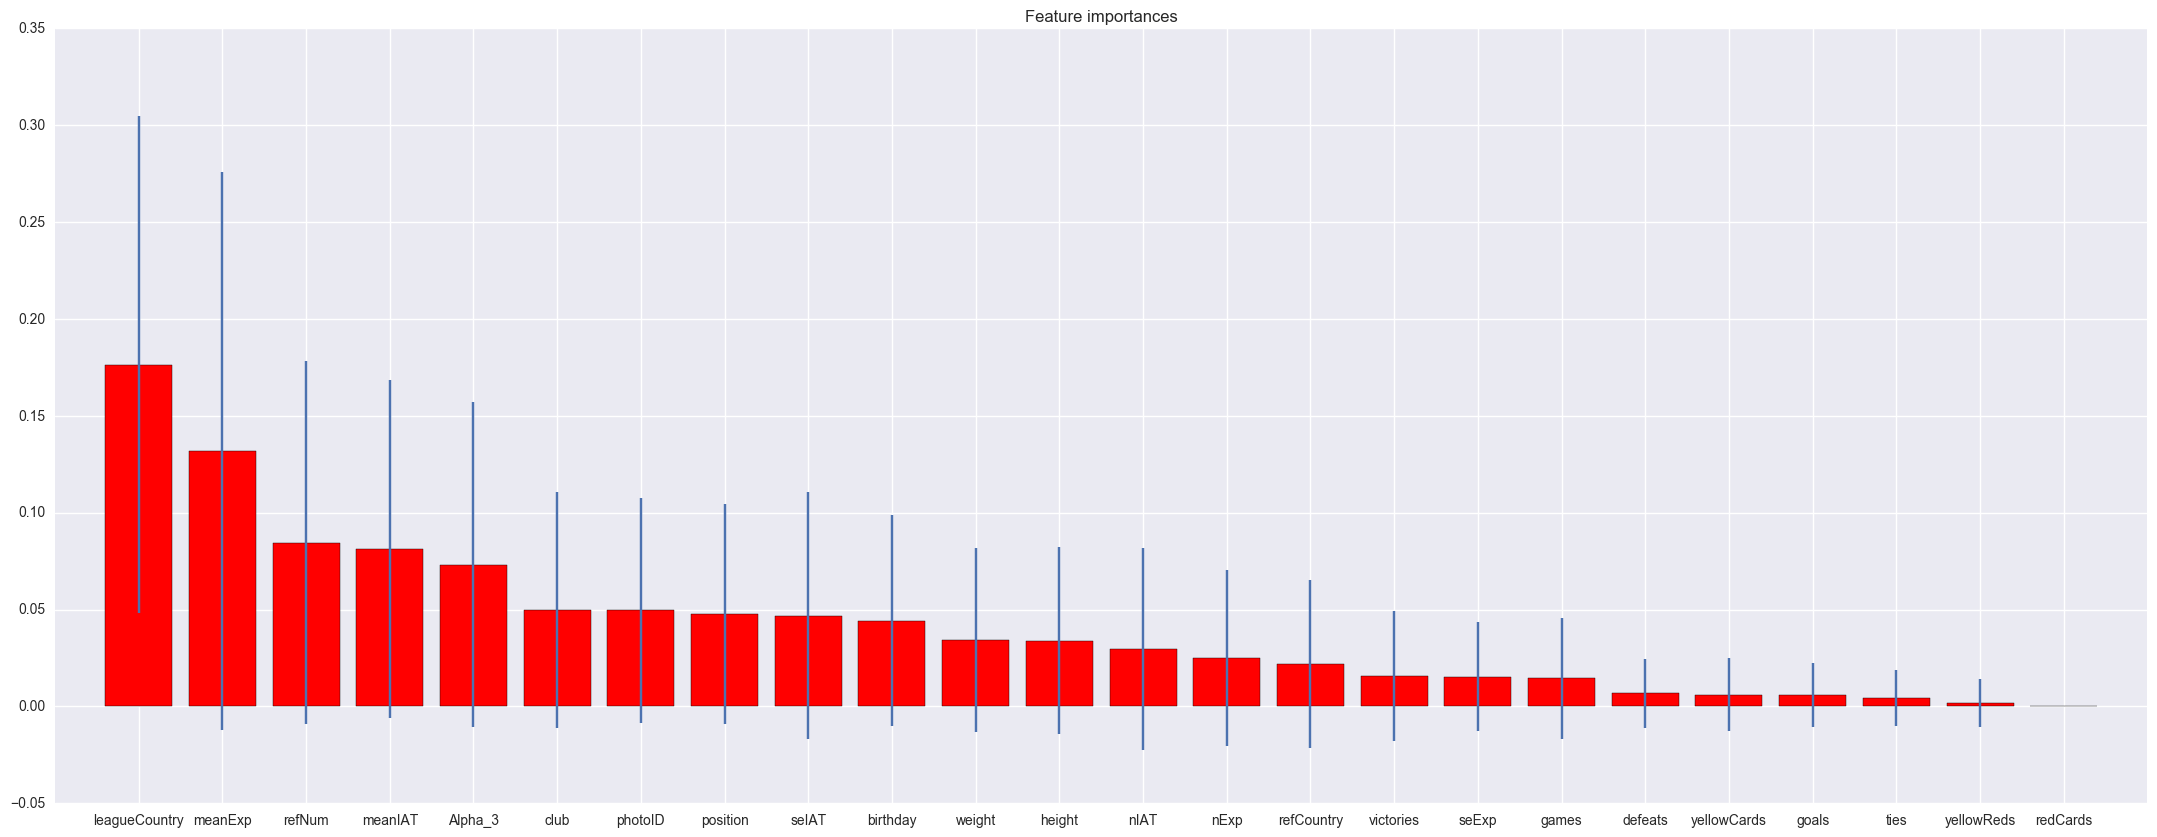

In [36]:
dev = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

importances = list(map(lambda x : x[0], indices))
indices = list(map(lambda x : x[1], indices))

plt.figure(figsize=(27, 10))
plt.title("Feature importances")
plt.bar(range(len(indices)), clf.feature_importances_[indices], yerr=dev[indices], align="center",color='r')
plt.xticks(range(len(indices)), [r.columns[i] for i in indices])
plt.xlim([-1, len(indices)])
plt.show()

Some features are obvious outliers, such as the photoID; there's really no reason it could be correlated.

Let's pick the first few ones that actually make sense: `meanExp`, `meanIAT`, `leagueCountry`, `club`, `weight` and `height`.

In [37]:
nfeatures = features[['leagueCountry', 'meanExp', 'meanIAT', 'club', 'weight', 'height']]

nX_train,  nX_test, ny_train, ny_test = train_test_split(nfeatures, r['skintone'], test_size=0.4)

forest = make_forest(n_features=3)

clf = forest.fit(nX_train, ny_train)

In [38]:
clf.score(nX_test, ny_test)

0.77003484320557491

In [39]:
score = cross_val_score(clf, X_test, y_test, cv=9)

print("Accuracy: %f with std of -+ %0.2f" % (score.mean(), score.std()*2))

Accuracy: 0.793102 with std of -+ 0.03


We've now got a pretty good accuracy with a pretty low variance, and a much simpler model!

Bonus: learning curve
====================

In [40]:
# from : http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

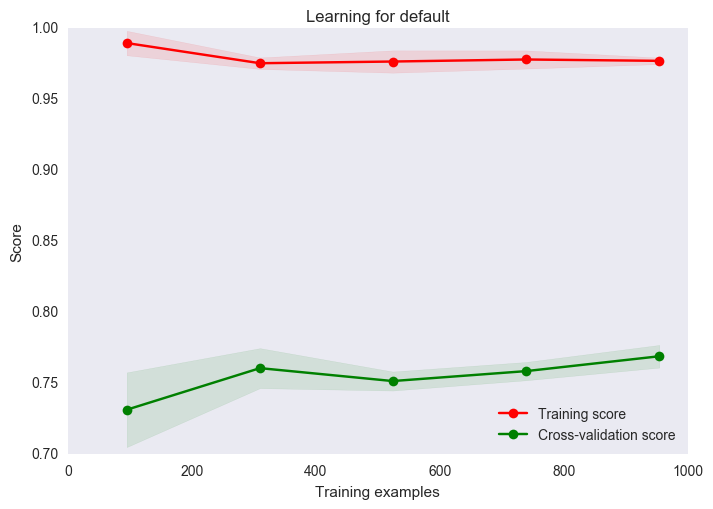

In [41]:
plot_learning_curve(RandomForestClassifier(), "Learning for default", features, r['skintone']).show()

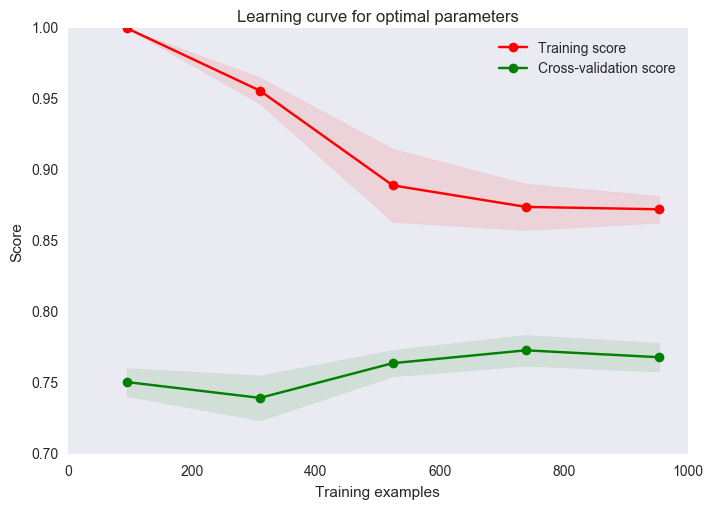

In [42]:
forest = RandomForestClassifier(n_estimators=22, max_features=5, max_depth=8)
plot_learning_curve(forest, "Learning curve for optimal parameters", features, r['skintone']).show()

2. Player clustering
===============

In [43]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [44]:
kmeans = KMeans(n_clusters=2)
reduced_data = PCA(n_components=2).fit_transform(features)

In [45]:
kmeans.fit(features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [46]:
# From http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

MemoryError: 

We can't seem to plot the cluster with the code from the examples of the sklearn documentation...

In [47]:
def partition_skin_length(data):
    return (len(data[data['skintone'] == 0]), len(data[data['skintone'] == 2]))

def cluster_lengths(data):
    return (len(data[data['cluster'] == 0]), len(data[data['cluster']== 1]))

def get_cluster(data, cnum):
    return data[data['cluster'] == cnum]

def cluster_skintone(data, cnum):
    return get_cluster(data, cnum).skintone.mean()

def mix_score(data):
    """Computes the discrepancy between black and whites inside of a cluster"""
    cluster1 = data[data['cluster'] == 0]
    cluster2 = data[data['cluster'] == 1]
    score = 0
    b1 = len(cluster1[cluster1['skintone'] == 1])
    b2 = len(cluster2[cluster2['skintone'] == 2])
    return np.abs(b1 - b2) / (b1 + b2) # This score should be as possible to 1 if good clustering

def clustering_score(data):
    cluster1 = data[data['cluster'] == 0]
    cluster2 = data[data['cluster'] == 1]
    c1_s = cluster1['skintone'].mean()
    c2_s = cluster2['skintone'].mean()
    return c1_s - c2_s     # This score should be as close as possible to 1 when good clustering
    
def skintone_diff(data):
    c1 = data['skintone'][data['cluster'] == 0].mean()
    c2 = data['skintone'][data['cluster'] == 1].mean()
    return  c1 - c2
    
def full_cluster_distrib(data):
    for i in pd.unique(data['cluster']):
        cluster = data[data['cluster'] == i]
        clen = len(cluster)
        w, b = partition_skin_length(cluster)
        print("Cluster %d has %d whites and %d black out of %d total" % (i, w, b, clen))
    print("Score: " + str(clustering_score(data)))
    
def make_cluster(data):
    return KMeans(n_clusters=2, max_iter=100, n_jobs=4, random_state=1234).fit_predict(data)

relevant_features = ['meanIAT', 'seIAT', 'meanExp', 'seExp', 'yellowCards', 'redCards', 'refCountry']

In [48]:
clusters = kmeans.predict(features)
clusters

array([1, 0, 0, ..., 1, 0, 1])

In [49]:
cluster = features.copy()
cluster['cluster'] = clusters
cluster['skintone'] = r['skintone']

full_cluster_distrib(cluster)

Cluster 1 has 555 whites and 0 black out of 711 total
Cluster 0 has 544 whites and 0 black out of 722 total
Score: 0.027128113421461708


The clustering seems to work very poorly for separating black and white people when using all the features present in the dataframe. Let us try to use only those that were useful during the classification.

In [50]:
from itertools import chain, combinations
from sklearn.metrics import silhouette_score

# From: https://stackoverflow.com/questions/18826571/python-powerset-of-a-given-set-with-generators
def powerset(s):
    pset = []
    i = set(s)
    for z in chain.from_iterable(combinations(i, r) for r in range(len(i)+1)):
        pset.append(z)
    return pset

scores = []

for s in list(powerset(relevant_features)): # We now test the score for every possible combinations of the referee features
    if len(s) == 0:
        continue # No use computing anything when we have no features
        
    uf = features[list(s)].copy()
    clabels = make_cluster(uf)
    sil_score = silhouette_score(uf, clabels)
    uf['skintone'] = r['skintone']
    uf['cluster'] = clabels
    scores.append((s, sil_score, clustering_score(uf), uf))

    
scores = sorted(scores, key=lambda k : k[2])

In [51]:
for s in scores:
    print("Clustering with " + str(s[0]) + " got a silhouette score of " + str(s[1]))

Clustering with ('meanIAT',) got a silhouette score of 0.694986004653
Clustering with ('redCards', 'meanIAT') got a silhouette score of 0.694614557726
Clustering with ('meanIAT', 'yellowCards') got a silhouette score of 0.684311794704
Clustering with ('redCards', 'meanIAT', 'yellowCards') got a silhouette score of 0.684044908088
Clustering with ('meanExp',) got a silhouette score of 0.732688182612
Clustering with ('redCards', 'meanExp') got a silhouette score of 0.73227736105
Clustering with ('yellowCards', 'meanExp') got a silhouette score of 0.720610331189
Clustering with ('redCards', 'yellowCards', 'meanExp') got a silhouette score of 0.720302382636
Clustering with ('meanIAT', 'meanExp') got a silhouette score of 0.576662972256
Clustering with ('redCards', 'meanIAT', 'meanExp') got a silhouette score of 0.576379621696
Clustering with ('meanIAT', 'yellowCards', 'meanExp') got a silhouette score of 0.569155077805
Clustering with ('redCards', 'meanIAT', 'yellowCards', 'meanExp') got a 

Let's now checkout which of these clustering provide a statistically significant difference in skin tone between the 2 clusters

In [52]:
from scipy.stats import ttest_ind

ssig = []

for s in scores:
    cl = s[3]
    s0 = cl['skintone'][cl['cluster'] == 0]
    s1 = cl['skintone'][cl['cluster'] == 1]
    
    t_stats, p_value = ttest_ind(s0, s1)
    
    print(s[0])
    print("P_value: " + str(p_value))
    print("Score: " + str(s[1]))
    if p_value < 0.05:
        ssig.append(s)

('meanIAT',)
P_value: 3.21677410896e-06
Score: 0.694986004653
('redCards', 'meanIAT')
P_value: 3.21677410896e-06
Score: 0.694614557726
('meanIAT', 'yellowCards')
P_value: 3.21677410896e-06
Score: 0.684311794704
('redCards', 'meanIAT', 'yellowCards')
P_value: 3.21677410896e-06
Score: 0.684044908088
('meanExp',)
P_value: 2.17688971564e-05
Score: 0.732688182612
('redCards', 'meanExp')
P_value: 2.17688971564e-05
Score: 0.73227736105
('yellowCards', 'meanExp')
P_value: 2.17688971564e-05
Score: 0.720610331189
('redCards', 'yellowCards', 'meanExp')
P_value: 2.17688971564e-05
Score: 0.720302382636
('meanIAT', 'meanExp')
P_value: 4.64151972379e-05
Score: 0.576662972256
('redCards', 'meanIAT', 'meanExp')
P_value: 4.64151972379e-05
Score: 0.576379621696
('meanIAT', 'yellowCards', 'meanExp')
P_value: 4.64151972379e-05
Score: 0.569155077805
('redCards', 'meanIAT', 'yellowCards', 'meanExp')
P_value: 4.64151972379e-05
Score: 0.568961670696
('seIAT',)
P_value: 7.7913258862e-05
Score: 0.769156604517
('

In [53]:
# Now we make a dataframe with the combinations that had a significant difference in skintone

rows = []

for s in ssig:
    rows.append((s[0], s[1], np.abs(skintone_diff(s[3])), cluster_skintone(s[3], 0), cluster_skintone(s[3], 1)))
    
final_df = pd.DataFrame(rows, columns=['features', 'silhouette', 'skintone_diff', 'c0_skintone', 'c1_skintone'])
final_df.sort_values(['skintone_diff', 'silhouette'], ascending=False)

,features,silhouette,skintone_diff,c0_skintone,c1_skintone
0,"(meanIAT,)",0.694986,0.104323,0.175274,0.279597
1,"(redCards, meanIAT)",0.694615,0.104323,0.175274,0.279597
2,"(meanIAT, yellowCards)",0.684312,0.104323,0.175274,0.279597
3,"(redCards, meanIAT, yellowCards)",0.684045,0.104323,0.175274,0.279597
4,"(meanExp,)",0.732688,0.097892,0.196667,0.294559
5,"(redCards, meanExp)",0.732277,0.097892,0.196667,0.294559
6,"(yellowCards, meanExp)",0.720610,0.097892,0.196667,0.294559
7,"(redCards, yellowCards, meanExp)",0.720302,0.097892,0.196667,0.294559
8,"(meanIAT, meanExp)",0.576663,0.093288,0.175725,0.269012
9,"(redCards, meanIAT, meanExp)",0.576380,0.093288,0.175725,0.269012


All in all it would seem that the maximum difference in skintone average we can get is 0.10, which is pretty low. This would suggest there is no obvious racism pattern among referees in the 4 major leagues we examined.